# Load Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model

from tensorflow.keras.backend import expand_dims
from tensorflow.keras.layers import Conv1D, Conv2D, BatchNormalization, Reshape, MaxPooling2D, Flatten, Concatenate, Dropout
from tensorflow.keras.layers import Dense

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

import keras
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

/export/home/lueders/LYNX-venv/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/export/home/lueders/LYNX-venv/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You ca

In [2]:
print("Creating embeddings.")
embeddings_index = {}
# add glove directory here
with open('') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

unknown_words =[]

Creating embeddings.
Found 1917494 word vectors.


# Variables & Dictionaries

In [ ]:
def calc_max_seq_len(data_df):
    titles = data_df['title']
    title_lengths = (titles.str.count(' ')+1).fillna(0).astype(np.int)
    max_title_len = title_lengths.quantile(0.95, interpolation='higher')
    print(max_title_len)

    descriptions = data_df['description']
    desc_lengths = (descriptions.str.count(' ')+1).fillna(0).astype(np.int)
    max_desc_len = desc_lengths.quantile(0.95, interpolation='higher')
    print(max_desc_len)
    
    return max_title_len + max_desc_len

In [4]:
SOURCE = "apache"
## 'apache', 243k, 
# 'mojang', 200k, 
## 'redhat', 106k
# 'jira', 98k

# 'mongodb', 38k
# 'qt', 36k

# 'sakai', 19k
# 'hyperledger', 16k 
# 'mariadb', 15k
# 'spring', 14k
# 'jiraecosystem', 11k

# 'sonatype', 4k, small
# 'jfrog', 3k, small
#'inteldaos', 3k too small DOES NOT WORK without properties

# 'secondlife', 630 too small
## 'mindville', 44 too small DOES NOT WORK

NL = True

In [5]:
type_dict={'Backports': 'Backport', 
           
    'Blocked': 'Block',
    'Blocker': 'Block',
    'Blocks': 'Block',
           
    'Bonfire Testing': 'Bonfire Testing', 
    'Bonfire testing': 'Bonfire Testing', 
    'Git Code Review': 'Bonfire Testing', 
    'Testing': 'Bonfire Testing',
           
    'Causality': 'Cause', 
    'Cause': 'Cause',
    'Caused': 'Cause', 
    'Problem/Incident': 'Cause',
           
    'Child-Issue': 'Parent-Child', 
    'Parent Feature': 'Parent-Child',
    'Parent/Child': 'Parent-Child',
    'multi-level hierarchy [GANTT]': 'Parent-Child',
    'Parent-Relation': 'Parent-Child',
           
    'Cloners': 'Clone', 
    'Cloners (old)': 'Clone', 
           
    'Collection': 'Incorporate', 
    'Container': 'Incorporate',
    'Contains(WBSGantt)': 'Incorporate', 
    'Incorporate': 'Incorporate', 
    'Incorporates': 'Incorporate', 
    'Part': 'Incorporate',
    'PartOf': 'Incorporate',
    'Superset': 'Incorporate', 
           
    'Completes': 'Fix', 
    'Fixes': 'Fix',
    'Resolve': 'Fix',
           
    'Depend': 'Depend', 
    'Dependency': 'Depend', 
    'Dependent': 'Depend', 
    'Depends': 'Depend', 
    'Gantt Dependency': 'Depend',
    'dependent': 'Depend',
           
    'Derived': 'Derive',
           
    'Detail': 'Detail', 
           
    'Documentation': 'Documented',
    'Documented': 'Documented',
    
    'Duplicate': 'Duplicate',
           
    'Epic': 'Epic', 
    'Epic-Relation': 'Epic',
    
    'Finish-to-Finish link (WBSGantt)': 'finish-finish', 
    'Gantt End to End': 'finish-finish', 
    'Gantt: finish-finish': 'finish-finish',
    'finish-finish [GANTT]': 'finish-finish', 
    
    'Gantt End to Start': 'finish-start', 
    'Gantt: finish-start': 'finish-start',
    'finish-start [GANTT]': 'finish-start',

    'Gantt Start to Start': 'start-start', 
    
    'Gantt: start-finish': 'start-finish', 
    
    'Follows': 'Follow', 
    'Sequence': 'Follow', 
    
    'Implement': 'Implement', 
    'Implements': 'Implements', 
    
    'Issue split': 'Split',
    'Split': 'Split',
    'Work Breakdown': 'Split',
    
    'Preceded By': 'Precede', 
    
    'Reference': 'Relate',
    'Relate': 'Relate',
    'Related': 'Relate', 
    'Relates': 'Relate',
    'Relationship': 'Relate',
    
    'Regression': 'Breaks', 
    
    'Replacement': 'Replace',
    
    'Required': 'Require', 
    
    'Supercedes': 'Supercede',
    'Supersede': 'Supercede',
    'Supersession': 'Supercede', 
    
    'Subtask': 'Subtask',
    
    'Test': 'Test', 
    'Tested': 'Test',
    
    'Trigger': 'Trigger'}

## Load Data

In [6]:
#Loading Issues & Links
filename = '../../data/processed/issues_'+SOURCE.lower()+'.csv'
issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=['issue_id'], sep=";")
print("Number of Issues: " + str(len(issues)))
print("Feature Size: " + str(len(list(issues.columns.values))))

if NL:
    filename = '../../data/processed/links_plus_'+SOURCE.lower()+'.csv'
    links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0, sep=";")
    print("Number of Links: " + str(len(links)))
    print("Feature Size: "+str(len(list(links.columns.values))))
else:
    filename = '../../data/processed/links_'+SOURCE.lower()+'.csv'
    links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0, sep=";")
    print("Number of Links: " + str(len(links)))
    print("Feature Size: "+str(len(list(links.columns.values))))

Number of Issues: 140237
Feature Size: 9
Number of Links: 35855
Feature Size: 5


In [ ]:
MAX_SEQUENCE_LENGTH = calc_max_seq_len(issues)
print(MAX_SEQUENCE_LENGTH)

In [7]:
import stanza

nlp = stanza.Pipeline(lang='en', processors='tokenize')

2021-12-08 11:16:52 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2021-12-08 11:16:52 INFO: Use device: gpu
2021-12-08 11:16:52 INFO: Loading: tokenize
2021-12-08 11:16:55 INFO: Done loading processors!


## Links preprocess

In [11]:
links.linktype.value_counts()

Subtask           8532
Relates           8015
Dependency        5884
Epic-Relation     4729
Duplicate         3827
Replacement       2542
Work Breakdown    2279
Test                47
Name: linktype, dtype: int64

In [12]:
links['mappedtype'] = links['linktype'].map(type_dict)
links.mappedtype.value_counts()

Subtask      8532
Relate       8015
Depend       5884
Epic         4729
Duplicate    3827
Replace      2542
Split        2279
Test           47
Name: mappedtype, dtype: int64

In [13]:
links.mappedtype.value_counts()>=len(links)*0.01

Subtask       True
Relate        True
Depend        True
Epic          True
Duplicate     True
Replace       True
Split         True
Test         False
Name: mappedtype, dtype: bool

In [14]:
linktypes = (links.mappedtype.value_counts()>=len(links)*0.01).rename_axis('mappedtype').reset_index(name='valid')
valid_types = set(linktypes[linktypes['valid']==True]['mappedtype'])

all_data = links[(links["mappedtype"].isin(valid_types))]

all_data['label'] = all_data['mappedtype'].factorize()[0].astype(int)

/tmp/ipykernel_3849026/4001403793.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['label'] = all_data['mappedtype'].factorize()[0].astype(int)


In [15]:
category_id_df = all_data[['mappedtype', 'label']].drop_duplicates().sort_values('label')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['label', 'mappedtype']].values)

print("Categories: "+str(len(id_to_category)))
print("Categories: "+str(id_to_category))

Categories: 7
Categories: {0: 'Duplicate', 1: 'Relate', 2: 'Split', 3: 'Depend', 4: 'Replace', 5: 'Subtask', 6: 'Epic'}


## Features / Embedding Matrix

In [16]:
issues['title'].fillna(' ', inplace=True)  
issues['description'].fillna(' ', inplace=True) 

In [17]:
issues['text'] = issues['title'] + ' ' + issues['description']

In [18]:
issue_feat_data = issues[['text']]

all_data = all_data.merge(issue_feat_data, left_on='issue_id_1', right_on='issue_id')
all_data = all_data.merge(issue_feat_data, left_on='issue_id_2', right_on='issue_id', suffixes=('_1', '_2'))

In [19]:
## Sanity Check
all_data.isnull().any()

name          False
linktype      False
issue_id_1    False
issue_id_2    False
issues        False
mappedtype    False
label         False
text_1        False
props_1       False
text_2        False
props_2       False
dtype: bool

In [20]:
from tqdm import tqdm

text_1 = []
text_2 = []

for i in tqdm(all_data.index):
    if not pd.isna(all_data['text_1'][i]):
        temp_doc = nlp(all_data['text_1'][i])
    #     print(temp_doc)
        temp_text_tokens = []
        for sentence in temp_doc.sentences:
            for token in sentence.tokens:
                temp_text_tokens.append(token.text)
        text_1.append(temp_text_tokens)
    else:
        text_1.append([' '])
        print(i)
    if not pd.isna(all_data['text_2'][i]):
        temp_doc = nlp(all_data['text_2'][i])
    #     print(temp_doc)
        temp_text_tokens = []
        for sentence in temp_doc.sentences:
            for token in sentence.tokens:
                temp_text_tokens.append(token.text)
        text_2.append(temp_text_tokens)
    else:
        text_2.append([' '])
        print(i)
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35808/35808 [37:54<00:00, 15.74it/s]


In [21]:
all_data['text_1_stanza']=list(text_1)
all_data['text_2_stanza']=list(text_2)

In [22]:
texts = all_data['text_1'].append(all_data['text_2'])
text_lengths = (texts.str.count(' ')+1).fillna(0).astype(np.int)
max_text_len = text_lengths.quantile(0.95, interpolation='higher')
print(max_text_len)

365


In [23]:
MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH
MAX_NUM_WORDS = 250000
EMBEDDING_DIM = 300
NO_LABELS = len(all_data.label.unique())

In [24]:
t1_texts = all_data['text_1_stanza'].tolist()
t2_texts = all_data['text_2_stanza'].tolist()

t_texts = t1_texts + t2_texts

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(t_texts)
t_sequences = tokenizer.texts_to_sequences(t_texts)

word_index_t = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index_t))

t_text_data = pad_sequences(t_sequences, maxlen=MAX_SEQUENCE_LENGTH)

num_words_t = min(MAX_NUM_WORDS, len(word_index_t) + 1)
embedding_matrix_T = np.zeros((num_words_t, EMBEDDING_DIM))
for word, i in word_index_t.items():
    if i >= MAX_NUM_WORDS:
        continue
    try:
        embedding_vector = embeddings_index[word]
    except KeyError:
        try:
            embedding_vector = embeddings_index[word.lower()]
        except KeyError:
            try:
                embedding_vector = embeddings_index[word.title()]
            except KeyError:
                unknown_words.append(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_T[i] = embedding_vector

Found 300522 unique tokens.


In [25]:
t1_text_data = t_text_data[:len(all_data),:]
t2_text_data = t_text_data[len(all_data):,:]

# Deep Learning Models

In [26]:
print("Creating functions.")
def plot_history(history):
#     keys = history.history.keys()
    for i in list(history.history)[0:2]:
        print(i)
        # list all data in history
        # summarize history for accuracy
        plt.plot(history.history[i])
#         plt.plot(history.history['val_'+i])
        plt.title('model '+ i)
        plt.ylabel(i)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

Creating functions.


### Embedding Model

In [27]:
print("Disabling eager execution.")
tf.compat.v1.disable_eager_execution()

print("Models incoming.")
# Title inputs
embedding_layer = Embedding(num_words_t,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_T),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
# from keras.layers import concatenate
text_in = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'Text_Input')
text_out = embedding_layer(text_in)

text_embedding = Model(inputs = [text_in], outputs = [text_out], name = 'Text_Output')

text_embedding.summary()

Disabling eager execution.
Models incoming.
Model: "Text_Output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_Input (InputLayer)     [(None, 365)]             0         
                                                                 
 embedding (Embedding)       (None, 365, 300)          75000000  
                                                                 
Total params: 75,000,000
Trainable params: 0
Non-trainable params: 75,000,000
_________________________________________________________________


In [28]:
# Pre-Model to reduce dimension of GLove
text_in = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='Text_Input')

text_out = text_embedding([text_in])

print(text_out.shape)

conv_1 = Conv1D(filters=150,
                    kernel_size=2,
                    strides=1,
                    activation='relu',
                    name="Branch1"
                   )(text_out)

conv_1 = BatchNormalization(axis=-1)(conv_1)

conv_2 = Conv1D(filters=20,
                    kernel_size=2,
                    strides=1,
                    activation='relu',
                    name="Branch2"
                   )(conv_1)

conv_2 = BatchNormalization(axis=-1)(conv_2)


glove_scale_down = Model(inputs = [text_in], outputs = [conv_2], name = 'Scale_Down')

glove_scale_down.summary()

(None, 365, 300)
Instructions for updating:
Colocations handled automatically by placer.
Model: "Scale_Down"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_Input (InputLayer)     [(None, 365)]             0         
                                                                 
 Text_Output (Functional)    (None, 365, 300)          75000000  
                                                                 
 Branch1 (Conv1D)            (None, 364, 150)          90150     
                                                                 
 batch_normalization (BatchN  (None, 364, 150)         600       
 ormalization)                                                   
                                                                 
 Branch2 (Conv1D)            (None, 363, 20)           6020      
                                                                 
 batch_normalization_1 (Batc  (No

### SC-CNN Model

In [29]:
def SCCNN_Model():
    text_in = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='Text_Input')

    text_out = glove_scale_down([text_in])
    
    text_out = expand_dims(text_out, axis=-1)

     # A branch
    conv_a = Conv2D(filters=100,
                    kernel_size=(2,20),
                    strides=(1,1),
                    activation='relu',
                    name="BranchA"
                   )(text_out)
    
    conv_a = BatchNormalization(axis=-1)(conv_a)

    conv_a_rs = Reshape((conv_a.shape[1],100,1))(conv_a)

    conv_a_1 = Conv2D(filters = 200,
                    kernel_size = (2,100),
                    strides=(1,1),
                    activation = 'relu',
                    name="BranchA1"
                    )(conv_a_rs)

    pooled_conv_a_1 = MaxPooling2D(pool_size=(conv_a_1.shape[1], 1), padding='valid')(conv_a_1)
#     pooled_conv_a_1 = GlobalMaxPooling2D()(conv_a_1)
    pooled_conv_a_1 = Flatten()(pooled_conv_a_1)

    conv_a_2 = Conv2D(filters = 200,
                    kernel_size = (3,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchA2"
                    )(conv_a_rs)

    pooled_conv_a_2 = MaxPooling2D(pool_size=(conv_a_2.shape[1], 1), padding='valid')(conv_a_2)
#     pooled_conv_a_2 = GlobalMaxPooling2D()(conv_a_2)
    pooled_conv_a_2 = Flatten()(pooled_conv_a_2)

    conv_a_3 = Conv2D(filters = 200,
                    kernel_size = (4,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchA3"
                    )(conv_a_rs)

    pooled_conv_a_3 = MaxPooling2D(pool_size=(conv_a_3.shape[1], 1), padding='valid')(conv_a_3)
#     pooled_conv_a_3 = GlobalMaxPooling2D()(conv_a_3)
    pooled_conv_a_3 = Flatten()(pooled_conv_a_3)
    
    A = Concatenate(axis=-1)([pooled_conv_a_1,pooled_conv_a_2])
    A = Concatenate(axis=-1)([A,pooled_conv_a_3])
    
    # B branch
    conv_b = Conv2D(filters=100,
                    kernel_size=(3,20),
                    activation='relu',
                    strides=(1,1),
                    name="BranchB"
                    )(text_out)

    conv_b = BatchNormalization(axis=-1)(conv_b)

    conv_b_rs = Reshape((conv_b.shape[1],100,1))(conv_b)

    conv_b_1 = Conv2D(filters = 200,
                    kernel_size = (2,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchB1"
                    )(conv_b_rs)

    pooled_conv_b_1 = MaxPooling2D(pool_size=(conv_b_1.shape[1], 1), padding='valid')(conv_b_1)
#     pooled_conv_b_1 = GlobalMaxPooling2D()(conv_b_1)
    pooled_conv_b_1 = Flatten()(pooled_conv_b_1)

    conv_b_2 = Conv2D(filters = 200,
                    kernel_size = (3,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchB2"
                    )(conv_b_rs)

    pooled_conv_b_2 = MaxPooling2D(pool_size=(conv_b_2.shape[1], 1), padding='valid')(conv_b_2)
#     pooled_conv_b_2 = GlobalMaxPooling2D()(conv_b_2)
    pooled_conv_b_2 = Flatten()(pooled_conv_b_2)

    conv_b_3 = Conv2D(filters = 200,
                    kernel_size = (4,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchB3"
                    )(conv_b_rs)

    pooled_conv_b_3 = MaxPooling2D(pool_size=(conv_b_3.shape[1], 1), padding='valid')(conv_b_3)
#     pooled_conv_b_3 = GlobalMaxPooling2D()(conv_b_3)
    pooled_conv_b_3 = Flatten()(pooled_conv_b_3)
    
    B = Concatenate(axis=-1)([pooled_conv_b_1,pooled_conv_b_2])
    B = Concatenate(axis=-1)([B,pooled_conv_b_3])

    # C branch
    conv_c = Conv2D(filters=100,
                    kernel_size=(4,20),
                    activation='relu',
                    strides=(1,1),
                    name="BranchC"
                    )(text_out)
    conv_c = BatchNormalization(axis=-1)(conv_c)

    conv_c_rs = Reshape((conv_c.shape[1],100,1))(conv_c)

    conv_c_1 = Conv2D(filters = 200,
                    kernel_size = (2,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchC1"
                    )(conv_c_rs)


    pooled_conv_c_1 = MaxPooling2D(pool_size=(conv_c_1.shape[1], 1), padding='valid')(conv_c_1)
#     pooled_conv_c_1 = GlobalMaxPooling2D()(conv_c_1)
    pooled_conv_c_1 = Flatten()(pooled_conv_c_1)

    conv_c_2 = Conv2D(filters = 200,
                    kernel_size = (3,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchC2"
                    )(conv_c_rs)

    pooled_conv_c_2 = MaxPooling2D(pool_size=(conv_c_2.shape[1], 1), padding='valid')(conv_c_2)
#     pooled_conv_c_2 = GlobalMaxPooling2D()(conv_c_2)
    pooled_conv_c_2 = Flatten()(pooled_conv_c_2)

    conv_c_3 = Conv2D(filters = 200,
                    kernel_size = (4,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchC3"
                    )(conv_c_rs)

    pooled_conv_c_3 = MaxPooling2D(pool_size=(conv_c_3.shape[1], 1), padding='valid')(conv_c_3)
#     pooled_conv_c_3 = GlobalMaxPooling2D()(conv_c_3)
    pooled_conv_c_3 = Flatten()(pooled_conv_c_3)
    
    C = Concatenate(axis=-1)([pooled_conv_c_1,pooled_conv_c_2])
    C = Concatenate(axis=-1)([C,pooled_conv_c_3])

    conv_concat = Concatenate(axis=-1)([A,B])
    conv_concat = Concatenate(axis=-1)([conv_concat,C])

    issue_model = Model(inputs = [text_in], outputs = [conv_concat], name = 'SC-CNN_Model')

#     issue_model.summary()
    return issue_model

### Complete Model

In [30]:
def get_model():
    text_in_a = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype='int32', name="Text_issue_a")
    text_in_b = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype='int32', name="Text_issue_b")
    
    prop_in_a = Input(shape = (PROPERTY_LENGTH,), dtype='float32', name="pr1")
    prop_in_b = Input(shape = (PROPERTY_LENGTH,), dtype='float32', name="pr2")
    
#     crea_in_a = Input(shape = (DATE_LENGTH,), dtype='float32', name="cr1")
#     crea_in_b = Input(shape = (DATE_LENGTH,), dtype='float32', name="cr2")
    
#     upda_in_a = Input(shape = (DATE_LENGTH,), dtype='float32', name="up1")
#     upda_in_b = Input(shape = (DATE_LENGTH,), dtype='float32', name="up2")

    issue_model = SCCNN_Model()

    encoded_issue_a = issue_model([text_in_a])
    encoded_issue_b = issue_model([text_in_b])

    merged_vector = Concatenate()([encoded_issue_a, encoded_issue_b, prop_in_a, prop_in_b,
#                                    crea_in_a, crea_in_b, upda_in_a, upda_in_b
                                  ])

    concat = Dropout(0.5)(merged_vector)
    concat = Dense(units = 512, 
                activation = 'relu',
                )(concat)
    concat = BatchNormalization(axis=-1)(concat)
    
    concat = Dropout(0.5)(concat)
    concat = Dense(units = 256, 
                activation = 'relu',
                )(concat)
    concat = BatchNormalization(axis=-1)(concat)
    
    concat = Dropout(0.5)(concat)
    concat = Dense(units = 128, 
                activation = 'relu',
                )(concat)
    concat = BatchNormalization(axis=-1)(concat)
    
    concat = Dropout(0.5)(concat)
    concat = Dense(units = 64, 
                activation = 'relu',
                )(concat)
    concat = BatchNormalization(axis=-1)(concat)
    
#     concat = Dropout(0.5)(concat)
#     concat = Dense(units = 128, 
#                 activation = 'relu',
#                 )(concat)
#     concat = BatchNormalization(axis=-1)(concat)
    
#     concat = Dropout(0.5)(concat)
#     concat = Dense(units = 256, 
#                 activation = 'relu',
#                 )(concat)
#     concat = BatchNormalization(axis=-1)(concat)
    
#     concat = Dropout(0.5)(concat)
#     concat = Dense(units = 128, 
#                 activation = 'relu',
#                 )(concat)
#     concat = BatchNormalization(axis=-1)(concat)
    
#     concat = Dropout(0.5)(concat)
#     concat = Dense(units = 64, 
#                 activation = 'relu',
#                 )(concat)
#     concat = BatchNormalization(axis=-1)(concat)
    
    model = Model(inputs=[text_in_a, text_in_b, prop_in_a, prop_in_b,
#                               crea_in_a, crea_in_b, upda_in_a, upda_in_b
                             ], outputs=concat)
#     sim_model.summary()

    
    return model

### Train Model

In [31]:
train, test = train_test_split(all_data, test_size = 0.2, random_state = 9)
print(len(train))
print(len(test))

28646
7162


In [32]:
def train_model(dataset):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2)
    
    class_weight = compute_class_weight(
                      class_weight='balanced',
                      classes=range(len(id_to_category)),
                      y=dataset['label']
                    )

    model = get_model()
    
    model.compile(optimizer='adam',
#                       Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
                      loss=tfa.losses.TripletSemiHardLoss())

    train_issue_1 = dataset['text_emb_1']
    train_issue_1 = np.array(train_issue_1.values.tolist())

    train_issue_2 = dataset['text_emb_2']
    train_issue_2 = np.array(train_issue_2.values.tolist())
    
    history = model.fit([train_issue_1, train_issue_2], 
                        y=dataset['label'], 
                            callbacks=[callback], 
                            validation_split=0.1, 
#                         class_weight = dict(enumerate(class_weight)), 
                        batch_size=128, epochs=64, verbose=2)
    
    plot_history(history)
    
    return model

2021-12-08 11:55:05.425439: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 11:55:06.001405: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20997 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1a:00.0, compute capability: 7.5


Train on 25781 samples, validate on 2865 samples
Epoch 1/100


2021-12-08 11:55:16.855504: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
/export/home/lueders/LYNX-venv/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


25781/25781 - 751s - loss: 0.8866 - val_loss: 0.8595 - 751s/epoch - 29ms/sample
Epoch 2/100
25781/25781 - 735s - loss: 0.7855 - val_loss: 0.6272 - 735s/epoch - 29ms/sample
Epoch 3/100
25781/25781 - 735s - loss: 0.6983 - val_loss: 0.6268 - 735s/epoch - 29ms/sample
Epoch 4/100
25781/25781 - 735s - loss: 0.6447 - val_loss: 0.6155 - 735s/epoch - 28ms/sample
Epoch 5/100
25781/25781 - 735s - loss: 0.6072 - val_loss: 0.5828 - 735s/epoch - 29ms/sample
Epoch 6/100
25781/25781 - 735s - loss: 0.5745 - val_loss: 0.5904 - 735s/epoch - 29ms/sample
Epoch 7/100
25781/25781 - 735s - loss: 0.5466 - val_loss: 0.5691 - 735s/epoch - 29ms/sample
Epoch 8/100
25781/25781 - 735s - loss: 0.5279 - val_loss: 0.6008 - 735s/epoch - 29ms/sample
Epoch 9/100
25781/25781 - 735s - loss: 0.5151 - val_loss: 0.5499 - 735s/epoch - 29ms/sample
Epoch 10/100
25781/25781 - 735s - loss: 0.4961 - val_loss: 0.5248 - 735s/epoch - 29ms/sample
Epoch 11/100
25781/25781 - 735s - loss: 0.4778 - val_loss: 0.5243 - 735s/epoch - 29ms/sampl

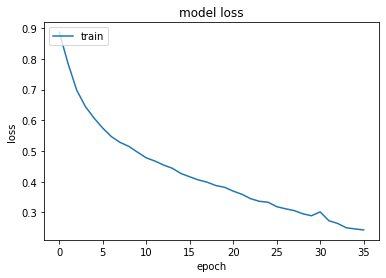

val_loss


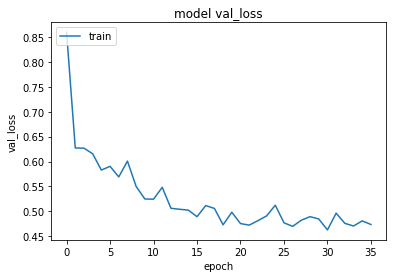

CPU times: user 1h 35min 6s, sys: 11min 19s, total: 1h 46min 26s
Wall time: 7h 21min 23s


In [33]:
%%time
class_model = train_model(train)

## Prediction

### SVM Model

In [34]:
issue_1_train = t1_text_data[train.index]

issue_2_train = t2_text_data[train.index]

results_train = class_model.predict([issue_1_train, issue_2_train])

/export/home/lueders/LYNX-venv/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [35]:
issue_1_test = t1_text_data[test.index]

issue_2_test = t2_text_data[test.index]

results_test = class_model.predict([issue_1_test, issue_2_test, prop_issue_1_test, prop_issue_2_test])

In [36]:
np.save(file='embeddings/train_embed_'+SOURCE+'_GLOVE.npy', arr=results_train)
np.save(file='embeddings/test_embed_'+SOURCE+'_GLOVE.npy', arr=results_test)

In [37]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=25, random_state=0)

clf.fit(results_train, train['label'])

CPU times: user 22.9 s, sys: 198 ms, total: 23.1 s
Wall time: 23.1 s


SVC(class_weight='balanced')

In [ ]:
probs = clf.predict_proba(results_test)
preds = clf.predict(results_test)

test['preds_SVM'] = preds

In [ ]:
train[['name', 'linktype', 'issue_id_1', 'issue_id_2', 'mappedtype', 'label']].to_csv('embeddings/train_df_LT'+SOURCE+'.csv')
test[['name', 'linktype', 'issue_id_1', 'issue_id_2', 'mappedtype', 'label', 'preds_SVM']].to_csv('embeddings/test_df_LT'+SOURCE+'.csv')

In [38]:
class_rep = classification_report(test['label'], test['preds_SVM'], output_dict=True, target_names=category_id_df.mappedtype.to_list())
class_rep_df = pd.DataFrame(class_rep).transpose()
print(class_rep_df)

conf_mat = confusion_matrix(test['preds_SVM'], test['label'])
conf_mat_df = pd.DataFrame(conf_mat).transpose()
conf_mat_df.rename(index=id_to_category, inplace=True)
conf_mat_df.rename(columns=id_to_category, inplace=True)
print(conf_mat_df)

class_rep_df.to_csv('results/class_rep_LT_'+SOURCE+"_GLOVE.csv")
conf_mat_df.to_csv('results/conf_mat_LT_'+SOURCE+"_GLOVE.csv")

              precision    recall  f1-score      support
Duplicate      0.318458  0.423181  0.363426   742.000000
Relate         0.481132  0.538509  0.508206  1610.000000
Split          0.171388  0.253669  0.204565   477.000000
Depend         0.761165  0.662162  0.708220  1184.000000
Replace        0.250000  0.009728  0.018727   514.000000
Subtask        0.917833  0.898154  0.907887  1679.000000
Epic           0.935385  0.953975  0.944588   956.000000
accuracy       0.629852  0.629852  0.629852     0.629852
macro avg      0.547909  0.534197  0.522231  7162.000000
weighted avg   0.636367  0.629852  0.622868  7162.000000
           Duplicate  Relate  Split  Depend  Replace  Subtask  Epic
Duplicate        314     336     66      20        1        3     2
Relate           350     867    247      98        5       26    17
Split            112     178    121      38        1       23     4
Depend            40     151    112     784        5       69    23
Replace          165     242     

In [ ]:
res_data

In [ ]:
train[['name', 'linktype', 'issue_id_1', 'issue_id_2', 'mappedtype', 'label']].to_csv('embeddings/train_df_'+SOURCE+'.csv')
test[['name', 'linktype', 'issue_id_1', 'issue_id_2', 'mappedtype', 'label', 'preds_SVM']].to_csv('embeddings/test_df_'+SOURCE+'.csv')

### Deep Learning Model

In [ ]:
# text_in_a = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype='int32', name="Text_issue_a")
# text_in_b = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype='int32', name="Text_issue_b")

# prop_in_a = Input(shape = (PROPERTY_LENGTH,), dtype='float32', name="pr1")
# prop_in_b = Input(shape = (PROPERTY_LENGTH,), dtype='float32', name="pr2")

# # crea_in_a = Input(shape = (DATE_LENGTH,), dtype='float32', name="cr1")
# # crea_in_b = Input(shape = (DATE_LENGTH,), dtype='float32', name="cr2")

# # upda_in_a = Input(shape = (DATE_LENGTH,), dtype='float32', name="up1")
# # upda_in_b = Input(shape = (DATE_LENGTH,), dtype='float32', name="up2")

# encoded_link = class_model([[text_in_a, text_in_b, prop_in_a, prop_in_b, 
# #                              crea_in_a, crea_in_b, upda_in_a, upda_in_b
#                             ]])

# print(encoded_link.shape)

# concat = Dense(units = 32, 
#             activation = 'relu',
#             )(encoded_link)
# concat = BatchNormalization(axis=-1)(concat)

# concat = Dropout(0.5)(concat)
# concat = Dense(units = 16, 
#             activation = 'relu',
#             )(concat)
# concat = BatchNormalization(axis=-1)(concat)

# concat = Dropout(0.5)(concat)
# concat = Dense(units = len(id_to_category), 
#             activation = 'sigmoid',
#             )(concat)
# concat = BatchNormalization(axis=-1)(concat)

# model = Model(inputs=[text_in_a, text_in_b, prop_in_a, prop_in_b,
# #                           crea_in_a, crea_in_b, upda_in_a, upda_in_b
#                          ], outputs=concat)
# model.summary()

In [ ]:
# model.compile(optimizer='adam',
# #                       Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
#                 loss = 'sparse_categorical_crossentropy', 
#                 metrics=['sparse_categorical_accuracy'])

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2)

# issue_1_train = t1_text_data[train.index]

# issue_2_train = t2_text_data[train.index]

# prop_issue_1_train = train['props_1']
# prop_issue_1_train = np.array(prop_issue_1_train.values.tolist())

# prop_issue_2_train = train['props_2']
# prop_issue_2_train = np.array(prop_issue_2_train.values.tolist())

# # created_issue_1_train = train['created_ar_1']
# # created_issue_1_train = np.array(created_issue_1_train.values.tolist())

# # created_issue_2_train = train['created_ar_2']
# # created_issue_2_train = np.array(created_issue_2_train.values.tolist())

# # updated_issue_1_train = train['updated_ar_1']
# # updated_issue_1_train = np.array(updated_issue_1_train.values.tolist())

# # updated_issue_2_train = train['updated_ar_2']
# # updated_issue_2_train = np.array(updated_issue_2_train.values.tolist())

# history = model.fit([issue_1_train, issue_2_train, prop_issue_1_train, prop_issue_2_train
# #                      ,created_issue_1_train, created_issue_2_train, updated_issue_1_train, updated_issue_2_train
#                             ], 
#                         y=train['label'], 
#                             callbacks=[callback], 
#                             validation_split=0.1, 
# #                         class_weight = dict(enumerate(class_weight)), 
#                         batch_size=128, epochs=20, verbose=2)

# plot_history(history)

In [ ]:
# issue_1_test = t1_text_data[test.index]

# issue_2_test = t2_text_data[test.index]

# prop_issue_1_test = test['props_1']
# prop_issue_1_test = np.array(prop_issue_1_test.values.tolist())

# prop_issue_2_test = test['props_2']
# prop_issue_2_test = np.array(prop_issue_2_test.values.tolist())

# # created_issue_1_test = test['created_ar_1']
# # created_issue_1_test = np.array(created_issue_1_test.values.tolist())

# # created_issue_2_test = test['created_ar_2']
# # created_issue_2_test = np.array(created_issue_2_test.values.tolist())

# # updated_issue_1_test = test['updated_ar_1']
# # updated_issue_1_test = np.array(updated_issue_1_test.values.tolist())

# # updated_issue_2_test = test['updated_ar_2']
# # updated_issue_2_test = np.array(updated_issue_2_test.values.tolist())

# results_test = model.predict([issue_1_test, issue_2_test, prop_issue_1_test, prop_issue_2_test
# #                               , created_issue_1_test, created_issue_2_test, updated_issue_1_test, updated_issue_2_test
#                              ])

In [ ]:
# preds = results_test.argmax(axis=-1)

# class_rep = classification_report(test['label'], preds, output_dict=True, target_names=category_id_df.mappedtype.to_list())
# class_rep_df = pd.DataFrame(class_rep).transpose()
# print(class_rep_df)

# conf_mat = confusion_matrix(preds, test['label'])
# conf_mat_df = pd.DataFrame(conf_mat).transpose()
# conf_mat_df.rename(index=id_to_category, inplace=True)
# conf_mat_df.rename(columns=id_to_category, inplace=True)
# print(conf_mat_df)

# # y_true = pd.Series(test['label'], name="Actual").map(id_to_category)
# # y_pred = pd.Series(preds, name="Predicted").map(id_to_category)
# # df_confusion = pd.crosstab(y_true, y_pred)

# class_rep_df.to_csv('results/class_rep_LT_'+SOURCE+"_DL.csv")
# conf_mat_df.to_csv('results/conf_mat_LT_'+SOURCE+"_DL.csv")


In [ ]:
# test['preds_DL'] = preds

# total=len(preds)
# true_lab=[]
# pred_lab=[]
# pred3_lab=[]
# text=[]
# countNo=[]
# countProb=[]
# countYes=[]
# predNo=[]
# predProb=[]
# predYes=[]
# correct_wrong=[]
# correct_wrong3=[]
# ogOutput=[]
# for dt, probs in zip(test.index, results_test):
#     temp = probs.argsort()[-3:][::-1]
#     tempPred = []
#     for k in temp:
#         tempPred.append(id_to_category[k])
#     result=test['preds_DL'][dt]
#     if result == test_df['label'][dt]:
#         correct_wrong.append(True)
#     else:
#         correct_wrong.append(False)
#     if test_df['label'][dt] in temp:
#         correct_wrong3.append(True)
#     else:
#         correct_wrong3.append(False)
#     text.append(test['name'][dt])
#     pred_lab.append(result)
#     true_lab.append(test['label'][dt])
#     pred3_lab.append(tempPred)
#     bla = 0
#     blu = 0
#     bli = 0
#     blaindex = []
#     bluindex = []
#     bliindex = []
#     j = 0
#     for i in probs:
#         if i <= -1:
#             bla += 1
#             blaindex.append(id_to_category[j])
#         elif i < 1:
#             blu += 1
#             bluindex.append(id_to_category[j])
#         else:
#             bli += 1
#             bliindex.append(id_to_category[j])
#         j += 1
#     countNo.append(bla)
#     countProb.append(blu)
#     countYes.append(bli)
#     predNo.append(blaindex)
#     predProb.append(bluindex)
#     predYes.append(bliindex)
#     ogOutput.append(probs)
    
# name_dict = {
#             'Name': text,
#             'Gold Label' : true_lab,
#             'Predicted Label': pred_lab,
#             'Predicted Top3 Label': pred3_lab,
#             'Correct': correct_wrong,
#             'Correct': correct_wrong3,
#             'No': countNo,
#             'Prob': countProb,
#             'Yes': countYes,
#             'NoPred': predNo,
#             'ProbPred': predProb,
#             'YesPred': predYes,
#             'OriginalOutput': ogOutput
#           }

# # res_data = pd.DataFrame(name_dict)

# res_data.to_csv("results/detailed_results_"+SOURCE+"_DL.csv", sep=';')

In [ ]:
# res_data